In [1]:
#Import packages
import numpy as np
from numpy import argmax
import pyspark.sql.functions as F
import snowflake.connector
import pandas as pd
import spacy
#from sparknlp.base import Finisher, DocumentAssembler
#from sparknlp.annotator import  Normalizer, LemmatizerModel, StopWordsCleaner, Tokenizer
#from pyspark.ml import Pipeline
#from pyspark.ml.feature import CountVectorizer, VectorAssembler, HashingTF, IDF, Tokenizer
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix, \
                            roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
12,application_1602509276980_0013,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#SPARK connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user='APP_SPARK_PROD',
    password='>6txhcQ*7&^Qrq`j'
    )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
query = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.locale, r.observations, \
ADD IN CASE WHEN HERE \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-09-23'  \
limit 100"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
#Careful not to get CNR for NR
#CNR, NR, PM - contains(r.observations, ',NR,')
#NR, PM - substring(r.observations, 1, 2) = 'NR'
#CNR, PM - DONT WANT
#Careful not to get SSC for SC
#PM, SC - 
#PM, SSC - DONT WANT
#PM, SC, SSC
#18 labels total - not including PM (doesn't yet include NOLABEL label - 19 labels with that)
query_testing = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.reviewer_location, r.observations, \
case when contains(r.observations, 'PM') then 1 else 0 end as PM, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR, \
case when contains(r.observations, 'PII') then 1 else 0 end as PII, \
case when contains(r.observations, 'PR') then 1 else 0 end as PR, \
case when contains(r.observations, 'CS') then 1 else 0 end as CS, \
case when contains(r.observations, 'DC') then 1 else 0 end as DC, \
case when contains(r.observations, 'CR') then 1 else 0 end as CR, \
case when contains(r.observations, 'FRD') then 1 else 0 end as FRD, \
case when contains(r.observations, 'TST') then 1 else 0 end as TST, \
case when contains(r.observations, 'CC') then 1 else 0 end as CC, \
case when contains(r.observations, ',SC') then 1 else 0 end as SC, \
case when contains(r.observations, 'PIM') then 1 else 0 end as PIM, \
case when contains(r.observations, 'LC') then 1 else 0 end as LC, \
case when contains(r.observations, 'WEB') then 1 else 0 end as WEB, \
case when contains(r.observations, 'FL') then 1 else 0 end as FL, \
case when contains(r.observations, 'SA') then 1 else 0 end as SA, \
case when contains(r.observations, 'URL') then 1 else 0 end as URL, \
case when contains(r.observations, 'CV') then 1 else 0 end as CV, \
case when contains(r.observations, 'US') then 1 else 0 end as US \
from analytics.review as r \
where r.locale in ('en_US','en_GB','en_CA') \
and r.created_date > '2019-09-01'  \
and contains(r.observations, 'PM') \
limit 500000"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews = pd.read_sql(query_testing, conn)
reviews.head(100)
#reviews.info()

#PULLING IN ALL REVIEWS SINCE '2019-09-01' (17,468,653) TAKES X MINS

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID        CREATED_DATE  ... CV US
0   272095741 2020-04-07 10:58:19  ...  0  0
1   272095763 2020-04-07 05:43:20  ...  0  0
2   272065154 2020-04-07 06:44:31  ...  0  0
3   272073884 2020-04-07 06:27:26  ...  0  0
4   272095635 2020-04-07 08:48:57  ...  0  0
..        ...                 ...  ... .. ..
95  272072715 2020-04-07 09:12:40  ...  0  0
96  272107694 2020-04-07 09:29:31  ...  0  0
97  272141737 2020-04-07 13:27:57  ...  0  0
98  272039512 2020-04-07 11:30:56  ...  0  0
99  272086696 2020-04-07 07:01:32  ...  0  0

[100 rows x 27 columns]

In [7]:
reviews.loc[reviews['REVIEWER_LOCATION'] == 'US', 'REVIEWER_LOCATION'] = 'USA'

#reviews['REVIEWER_LOCATION'].head(500)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
#Use set_option so text doesn't truncate
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#reviews['LABEL_SUM']= reviews.iloc[:, -18:-1].sum(axis=1)
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
#LOOK AT OTHER LABELS - IF NONE THEN ADD NOLABEL = 1
#df['new column name'] = df['column name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
#reviews['NOLABEL'] = reviews['LABEL_SUM'].apply(lambda x: int(1) if x==0 else int(0))

#df.loc[df['set_of_numbers'] <= 4, 'equal_or_lower_than_4?'] = 'True' 
#reviews.loc[reviews['NOLABEL'] == 0, 'TEST'] = 1
#df['Fruit Total']= df.iloc[:, -4:-1].sum(axis=1)
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
#reviews2 = reviews.drop(['LABEL_SUM'], axis=1)
#reviews2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
#reviews = reviews2
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID                        int64
CREATED_DATE         datetime64[ns]
REVIEW_HEADLINE              object
REVIEW_COMMENTS              object
REVIEW_RATING                 int64
REVIEWER_NICKNAME            object
REVIEWER_LOCATION            object
OBSERVATIONS                 object
PM                            int64
NR                            int64
PII                           int64
PR                            int64
CS                            int64
DC                            int64
CR                            int64
FRD                           int64
TST                           int64
CC                            int64
SC                            int64
PIM                           int64
LC                            int64
WEB                           int64
FL                            int64
SA                            int64
URL                           int64
CV                            int64
US                            int64
dtype: object

In [13]:
reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS'] + \
        ' nickname ' + reviews['REVIEWER_NICKNAME'] + ' location ' + reviews['REVIEWER_LOCATION']
#Use set_option so text doesn't truncate
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID        CREATED_DATE  \
0   272095741 2020-04-07 10:58:19   
1   272095763 2020-04-07 05:43:20   
2   272065154 2020-04-07 06:44:31   
3   272073884 2020-04-07 06:27:26   
4   272095635 2020-04-07 08:48:57   
..        ...                 ...   
95  272072715 2020-04-07 09:12:40   
96  272107694 2020-04-07 09:29:31   
97  272141737 2020-04-07 13:27:57   
98  272039512 2020-04-07 11:30:56   
99  272086696 2020-04-07 07:01:32   

                                    REVIEW_HEADLINE  \
0   Delicious                                         
1   Good Stuff                                        
2   Steak treats                                      
3   A good base to start with !                       
4   Olive oil that is great in your Italian recipes   
..                                              ...   
95  Lots of Power                                     
96  Not the same as the photo!!                       
97  Caretaker                                         
98  G

In [14]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID               int64         
CREATED_DATE         datetime64[ns]
REVIEW_HEADLINE      object        
REVIEW_COMMENTS      object        
REVIEW_RATING        int64         
REVIEWER_NICKNAME    object        
REVIEWER_LOCATION    object        
OBSERVATIONS         object        
PM                   int64         
NR                   int64         
PII                  int64         
PR                   int64         
CS                   int64         
DC                   int64         
CR                   int64         
FRD                  int64         
TST                  int64         
CC                   int64         
SC                   int64         
PIM                  int64         
LC                   int64         
WEB                  int64         
FL                   int64         
SA                   int64         
URL                  int64         
CV                   int64         
US                   int64         
ALL_TEXT             object 

In [15]:


#reviews['PRICE'] = bool(re.match('location', str(reviews['ALL_TEXT'])))
#reviews[reviews['PRICE']==True].head()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
X = reviews[['ALL_TEXT','REVIEW_RATING']]
X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                         ALL_TEXT  \
0       headline Delicious comment I was able to try a free sample of Cobram Estate California Select Extra Virgin Olive Oil. I received it through PinchMe.com. I highly recommend this product. It has a delicious light taste to it. It?s not bitter like some Olive Oils can be. I will be purchasing this soon for my family and I to use. nickname LadyC location undisclosed                                                 
1       headline Good Stuff comment I recieved a sample of Cobram Estate California Select Extra Virgin Olive Oil from pinchme.com. I made salad dressing with

In [17]:
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US','NOLABEL']]
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US']]
y = reviews[['NR']]
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        NR
0       0 
1       0 
2       0 
3       0 
4       0 
...    .. 
499995  0 
499996  0 
499997  0 
499998  0 
499999  0 

[500000 rows x 1 columns]

In [18]:
y.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    8116
dtype: int64

In [19]:
#test_size is what % of data goes to test set vs training
#random_state - use so that when comparing models - same data is always going to test and train sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9, stratify = y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
print(xtrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ALL_TEXT  \
20962   headline Composite sink comment Love this sink, it looks far more expensive than its price, it's a great price for a composite sink, a much deeper bowl than my previous one, it has made my kitchen look far more contemporary. nickname joanne location Undisclosed       

In [21]:
#analyzer : default = word, can also test n_grams
#max_df :  ignore terms that have a document frequency strictly higher than the given threshold
#max_features : set total # of features used
vectorizer = TfidfVectorizer(ngram_range = (2,2), max_features = 30000, stop_words= 'english', lowercase=True)
#vectors = vectorizer.fit_transform(reviews['ALL_TEXT'].values.astype('U'))
tfidf_vectors_xtrain = vectorizer.fit_transform(xtrain['ALL_TEXT'].apply(lambda x: np.str_(x)))
tfidf_vectors_xtest = vectorizer.transform(xtest['ALL_TEXT'].apply(lambda x: np.str_(x)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
print(tfidf_vectors_xtrain)
#print(tfidf_vectors_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  (0, 15749)	0.0836655295451341
  (0, 13211)	0.4632750202396549
  (0, 19045)	0.4615949200483117
  (0, 10530)	0.29026439042986
  (0, 21599)	0.38024760465631713
  (0, 7804)	0.548779895520205
  (0, 4565)	0.18789740191875998
  (1, 25778)	0.33428459953035283
  (1, 29946)	0.3360603555847141
  (1, 17393)	0.3929712125176414
  (1, 22400)	0.28404170435824083
  (1, 3833)	0.3640309796174148
  (1, 8599)	0.2683589322354809
  (1, 590)	0.3321179973168104
  (1, 4728)	0.3864985722997745
  (1, 23238)	0.1481286593391268
  (1, 26175)	0.14813573379816145
  (1, 12101)	0.1692164332496664
  (1, 15749)	0.058924548774233226
  (2, 26503)	0.4473749779689421
  (2, 15721)	0.43770627770759973
  (2, 24688)	0.27785928515722713
  (2, 5846)	0.5054276442424455
  (2, 24611)	0.3175561587801975
  (2, 12030)	0.38160600300903097
  :	:
  (399998, 20517)	0.22614666096545882
  (399998, 13412)	0.2341868255915618
  (399998, 3801)	0.20748845497528018
  (399998, 12868)	0.2457312418794761
  (399998, 24892)	0.22475791704896575
  (39999

In [23]:
#Test to see what output looks like - don't use for modeling - dense vectors are memory intensive
#feature_names = vectorizer.get_feature_names()
#dense = tfidf_vectors_xtrain.todense()
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
#Convert ratings to sparse vector so can join to TF-IDF sparse vector
ratings_vector_xtrain=sparse.csr_matrix((xtrain['REVIEW_RATING']/5).values).reshape(400000,1)
#print(ratings_vector_xtrain)
ratings_vector_xtest=sparse.csr_matrix((xtest['REVIEW_RATING']/5).values).reshape(100000,1)
#print(ratings_vector_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
#Combine TF-IDF and ratings vectors
xtrain_final = sparse.hstack([tfidf_vectors_xtrain, ratings_vector_xtrain])
#print(xtrain_final)
xtest_final = sparse.hstack([tfidf_vectors_xtest, ratings_vector_xtest])
#print(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
#max_iter : default =100 but getting error about not converging
lr = LogisticRegression(max_iter=1000)
clf = OneVsRestClassifier(lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
#UserWarning: Label not 17 is present in all training examples.
#Due to fact that 'US' does not appear in training set (is all 0s) 
#RESOLVES AS DATA SIZE INCREASES

#Getting max iteration exceeded error
#All TF-IDF features are range 0-1, scaled rating to be divided by 5 so that is also range 0-1
#Lower max_features for TF-IDF to reduce dimensionality


clf.fit(xtrain_final, ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

LogisticRegression(max_iter=1000)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)

In [84]:
#ytrain.dtypes
#NO US LABEL
ytrain.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    6493
dtype: int64

In [85]:
y_pred = clf.predict(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
%matplotlib inline

In [88]:
#Confusion matrix
#confusion_matrix(ytest, y_pred)
#tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
#print("TN: {}".format(tn), "FP: {}".format(fp), "FN: {}".format(fn), "TP: {}".format(tp))
plot_confusion_matrix(clf, xtest_final, ytest)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

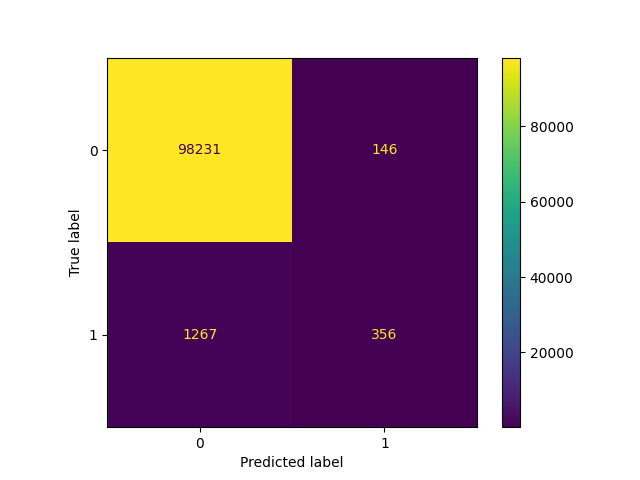

In [89]:
%matplot plt

In [90]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [91]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.98587
Precision is:  0.7091633466135459
Recall is:  0.21934688847812692
F1 Score is:  0.33505882352941174

In [92]:
print(classification_report(ytest,y_pred))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     98377
           1       0.71      0.22      0.34      1623

    accuracy                           0.99    100000
   macro avg       0.85      0.61      0.66    100000
weighted avg       0.98      0.99      0.98    100000

In [93]:
probs = clf.predict_proba(xtest_final)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'numpy.float64' object is not callable
Traceback (most recent call last):
TypeError: 'numpy.float64' object is not callable



In [94]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
#ROC CURVE
#Assumes we care about 0 and 1 classification the same - we don't
#We care more about performance of 1 classification - use precision recall curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

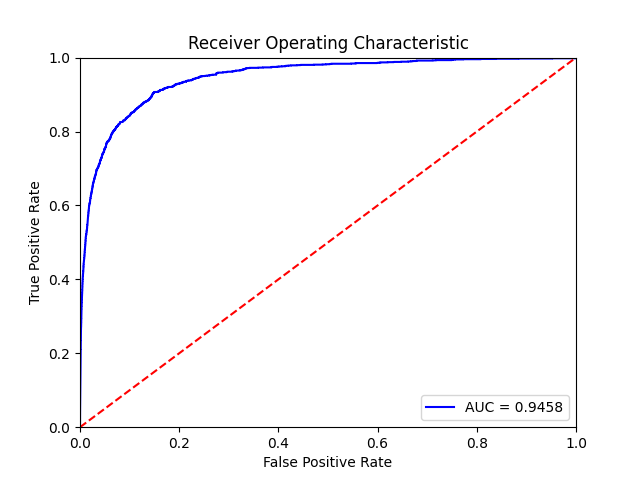

In [69]:
%matplot plt

In [70]:
#Find best threshold (ROC Curve)
#Ideally want tpr = 1 and fpr = 0, so want tpr - fpr as close to 1 as possible
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
opt_tpr = tpr[optimal_idx]
opt_fpr = fpr[optimal_idx]
print("Optimal threshold value:", optimal_threshold)
print("Optimal tpr value:", opt_tpr)
print("Optimal fpr value:", opt_fpr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optimal threshold value: 0.013326485507870325

In [71]:
t = optimal_threshold
y_pred_new = (preds >= t).astype(int)
#y_pred_new

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
#Scores with best threshold cutoff
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred_new)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred_new)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred_new)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred_new)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.85176
Precision is:  0.09112308740630613
Recall is:  0.9063462723351817
F1 Score is:  0.16559720815039963

In [73]:
len(y_pred_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

100000

In [74]:
#PRECISION RECALL CURVE
#Better for what we want to assess which is how well label is assigned (i.e. when it gets a 1 instead of a 0)

precision, recall, pr_threshold = precision_recall_curve(ytest, preds)
auc = auc(recall, precision)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
plt.title('Precision - Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc = 'lower right')
no_skill = len(ytest[ytest['NR']==1]) / len(ytest)
plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

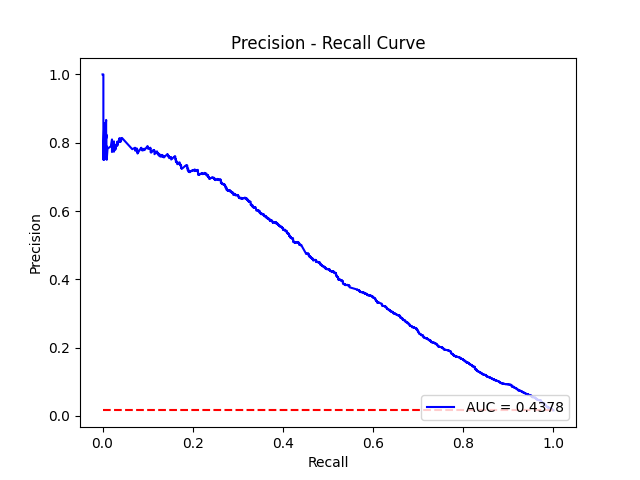

In [77]:
%matplot plt

In [78]:
#Best F1 score optimizes precision recall trade off

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_threshold[ix], fscore[ix]))

print('Recall=%f' % recall[ix])
print('Precision=%f' % precision[ix])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Threshold=0.202842, F-Score=0.469
Recall=0.440542
Precision=0.500700

In [79]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
plt.hist(preds, bins=10)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

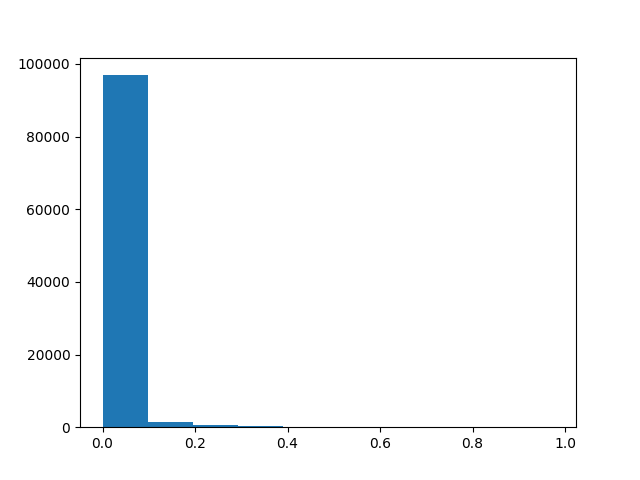

In [81]:
%matplot plt

In [50]:
#LOGISTIC REGRESSION

#Single tokens
#data set = 500,000
#max_features = 30000
#Best Threshold=0.209417, F-Score=0.498
#Recall 0.49516908212560384
#Precision 0.5012224938875306


#Single tokens
#data set = 500,000
#max_features = 50000
#Best Threshold=0.200349, F-Score=0.499
#Recall=0.504227
#Precision=0.494083

#Single tokens
#data set = 5,000,000
#max_features = 50000
#Best Threshold=0.200349, F-Score=0.499
#Recall=0.504227
#Precision=0.494083

#2 n-grams
#data set = 5,000,000
#max_features = 50000
#Best Threshold=0.221356, F-Score=0.484
#Recall=0.471806
#Precision=0.495870

#3 n-grams
#data set = 5,000,000
#max_features = 50000


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…